# Warren Buffet and Media General

FINM 35500

Spring 2022

Mark Hendricks


## The Situation

Case is in 2012.

Media General (MEG) is a conglomerate media firm.

They are in trouble.
- Too much debt (84% debt-to-book), 
- Losses year-after-year 
- Shrinking revenues

Berkshire Hathaway, led by Warren Buffett, sees an opportunity.
- Offer for the newspaper division of MEG
- Surprises investors, by 2012 newspapers are struggling.
- Even NYT had just taken a large loan from Carlos Slim

## The Offer

- \$142mm for the newspapers (minus Tampa Tribune)
- Additionally BH will make $400mm loan to MEG with 11.5% discount.
- BH will get 4.65mm penny warrants (19.9% of MEG's equity.) Expire in 2020.

## Issues to Analyze

- Should MEG take the deal?
- Why is BH getting involved with the loan?
- Are the warrants valuable?

## Our Motive

- This case is a good illustration of why we need new methods.
- How would we use quant asset pricing to value subsidiary of a single firm?
- Good walkthrough of DCF valuation.
- Along the way, many interesting business points.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

# Parameters and Assumptions

In [2]:
p0mediagen = 142
v0tampa = 30
taxRate = .35
rDebt = .07
g = -.06
rf = .03
betaD = .2
premMkt = .06
wE = .8

parameters = pd.DataFrame({'Parameter': ['purchase price', 'value of Tampa Trib', 'corp tax rate',
                                        'interest rate on target debt', 'perpetual growth rate',
                                        'risk-free rate', 'debt beta', 'market premium', 'target equity funding',
                                        'selected comparisons'],
                                'Value': [142, 30, 0.35, 0.07, -.06, 0.03, 0.20, 0.06, 0.80, 'A.H. Bel, Gannett'],
                                'Source': ['case text','case text','case text',
                                           'assumption that B-rated, use Exhibit 11', 'assumption',
                                           'assumption that 30yr-Tbond, use Exhibit 11',
                                          'assumption', 'assumption', 'assumption, supported by comp data',
                                          'Exhibit 12, matched to similar business assets']
                               })
parameters = parameters.set_index('Parameter')
parameters

,Value,Source
Parameter,,
purchase price,142,case text
value of Tampa Trib,30,case text
corp tax rate,0.35,case text
interest rate on target debt,0.07,"assumption that B-rated, use Exhibit 11"
perpetual growth rate,-0.06,assumption
risk-free rate,0.03,"assumption that 30yr-Tbond, use Exhibit 11"
debt beta,0.20,assumption
market premium,0.06,assumption
target equity funding,0.80,"assumption, supported by comp data"


# Load Tables

In [3]:
path_load_exhibits = 'exhibits/BuffettsBid_exhibits.xlsx'
tab_comps = pd.read_excel(path_load_exhibits,sheet_name='Exhibit 12',skiprows=6,usecols="B,E:H,J:K")
tab_comps = tab_comps.set_index(['Company'])
tab_comps['Revenue'] = pd.to_numeric(tab_comps['Revenue'], errors='coerce')
tab_comps = tab_comps.dropna(subset=['Revenue'])
tab_comps

,Revenue,Assets,Debt,Equity,D/V (a),Beta (b)
Company,,,,,,
Media General,616.20,"1,086.00",658.00,34.00,0.84,2.29
A.H. Belo Corp.,461.50,345.10,0.00,121.50,0.00,1.49
Beasley Broadcast Group,97.70,255.00,126.70,73.60,0.60,1.11
Courier Corp. (c),259.40,213.00,21.50,154.30,0.11,1.21
"Gannett Co., Inc.","5,240.00","6,616.50","1,760.40","2,327.90",0.41,2.11
Journal Comm. Inc.,356.80,417.70,41.70,205.00,0.31,2.24
Saga Communications,125.30,190.30,69.10,93.00,0.52,1.05


In [4]:
tab_income = pd.read_excel(path_load_exhibits,sheet_name='Exhibit 10',skiprows=4,usecols="B:C,E:I,K:O")
tab_income = tab_income.dropna(subset=['2016F'])
rows_merge = tab_income['Item'].isna()
tab_income.loc[rows_merge,'Item'] = tab_income.loc[rows_merge,'Unnamed: 2']
tab_income = tab_income.set_index(['Item'])
tab_income = tab_income.iloc[:,1:]

tab_income

,2007A,2008A,2009A,2010A,2011A,2012F,2013F,2014F,2015F,2016F
Item,,,,,,,,,,
Newspaper Revenues,524.80,436.90,357.50,328.40,299.50,287.10,282.50,288.10,293.90,299.82
Revenue Growth Rate,NaN,-0.17,-0.18,-0.08,-0.09,-0.04,-0.02,0.02,0.02,0.02
Operating Profit (EBIT),NaN,30.20,40.10,26.50,6.30,14.20,13.70,21.30,28.10,29.98
Operating Margin,NaN,0.07,0.11,0.08,0.02,0.05,0.05,0.07,0.10,0.10
Deprec./Amortization,NaN,27.70,24.90,22.80,22.10,20.00,16.00,12.00,9.00,6.00
Capital Expenditures,NaN,16.30,6.20,5.50,3.50,5.00,5.50,5.90,6.00,6.00
Net Working Capital,26.24,21.84,17.88,16.42,14.98,14.36,14.12,14.41,14.70,14.99


# Calculate FCF

Free Cashflow-to-Assets is the cash available to **all** investors.
- do NOT subtract dividends
- do NOT subtract interest payments

Key is to get
- Net operating profit after tax (NOPAT)
- Also known as Earnings-before-interest-after-taxes (EBIAT)

From there, subtract investment
- long-term investment, known as Capital Expenditures (CapEx)
- short-term capital, known as Net Working Capital (NWC)
- add back depreciation and amortization 

Compared to how accountants do it:
- Subtract investment when it is actually spent, not on an amortized schedule.
- Recognizes the time-value of money and certainty of money spent versus asset on the books.

In [5]:
%%capture --no-display

rowlocs = ['Newspaper Revenues','Operating Profit (EBIT)']
cf = tab_income.loc[rowlocs]

cf.loc['-Tax'] = -cf.loc['Operating Profit (EBIT)'] * parameters.loc['corp tax rate','Value']
cf.loc['=EBIAT'] = cf.loc['Operating Profit (EBIT)'] + cf.loc['-Tax']
cf.loc['Dep.& Amort.'] = tab_income.loc['Deprec./Amortization']
cf.loc['-Capex'] = - tab_income.loc['Capital Expenditures']
cf = cf.append(-tab_income.loc['Net Working Capital'].diff().rename('-Diff NWC'))
cf.loc['FCF'] = cf.iloc[3:].sum()
cf

,2007A,2008A,2009A,2010A,2011A,2012F,2013F,2014F,2015F,2016F
Item,,,,,,,,,,
Newspaper Revenues,524.80,436.90,357.50,328.40,299.50,287.10,282.50,288.10,293.90,299.82
Operating Profit (EBIT),NaN,30.20,40.10,26.50,6.30,14.20,13.70,21.30,28.10,29.98
-Tax,NaN,-10.57,-14.04,-9.27,-2.21,-4.97,-4.80,-7.45,-9.83,-10.49
=EBIAT,NaN,19.63,26.07,17.23,4.10,9.23,8.91,13.84,18.27,19.49
Dep.& Amort.,NaN,27.70,24.90,22.80,22.10,20.00,16.00,12.00,9.00,6.00
-Capex,NaN,-16.30,-6.20,-5.50,-3.50,-5.00,-5.50,-5.90,-6.00,-6.00
-Diff NWC,NaN,4.39,3.97,1.46,1.44,0.62,0.23,-0.28,-0.29,-0.30
FCF,0.00,35.42,48.74,35.98,24.14,24.85,19.64,19.66,20.98,19.19


# Estimate Discount Rate

Three steps:

1. Choose a comparable firm, or multiple comparables.
2. Unlever the equity beta of the comp to get its asset beta:
3. Use the asset pricing model to get the discount rate:

\begin{align*}
\beta_{iA} =& \; \beta_{jA}\\
\beta_{jA} =& \; w_{jD}\beta_{jD} + (1-w_{jD})\beta_{jE}\\
\overline{r}_{iA} =& \; r_{f} + \beta_{iA}\lambda_{\text{mkt}}
\end{align*}


In [6]:
compfirms = ['A.H. Belo Corp.', 'Gannett Co., Inc.']
comps = tab_comps.loc[compfirms]
#comps = tab_comps
comps = comps.rename(columns={'Beta (b)':'Equity beta', 'D/V (a)':'D/V (Mkt,2yr)'})

comps['Asset beta'] = comps.loc[:,'D/V (Mkt,2yr)'] * betaD + (1-comps.loc[:,'D/V (Mkt,2yr)']) * comps.loc[:,'Equity beta']
comps.loc['Average',:] = comps.mean(axis=0,skipna=True)
comps['Asset disc. rate'] = parameters.loc['risk-free rate','Value'] + comps['Asset beta'] * parameters.loc['market premium','Value']
comps.loc['Target',['Asset beta','Asset disc. rate']] = comps.loc['Average',['Asset beta','Asset disc. rate']]

comps.style.format({
    'Revenue': '{:.2f}'.format,
    'Assets': '{:.2f}'.format,
    'Debt': '{:.2f}'.format,
    'Equity': '{:.2f}'.format,
    'D/V (Mkt,2yr)': '{:.2f}'.format,
    'Equity beta': '{:.2f}'.format,
    'Asset beta': '{:.2f}'.format,
    'Asset disc. rate': '{:.2%}'.format,
})


,Revenue,Assets,Debt,Equity,"D/V (Mkt,2yr)",Equity beta,Asset beta,Asset disc. rate
Company,,,,,,,,
A.H. Belo Corp.,461.50,345.10,0.00,121.50,0.00,1.49,1.49,11.94%
"Gannett Co., Inc.",5240.00,6616.50,1760.40,2327.90,0.41,2.11,1.33,10.96%
Average,2850.75,3480.80,880.20,1224.70,0.20,1.80,1.41,11.45%
Target,nan,nan,nan,nan,nan,nan,1.41,11.45%


# NPV Function

We now have...
1. Expected cash flows
2. Discount rate
3. Terminal growth rate

Calculate the NPV with,
\begin{align*}
\text{NPV} = \sum_{h=1}^H\frac{\overline{C}_{iA,t+h}}{\overline{r}_{iA}} + \underbrace{\frac{1+\overline{g}_{iA}}{\overline{r}_{iA}-\overline{g}_{iA}}\overline{C}_{iA,t+H}}_{\text{Terminal value}}\;  - \underbrace{P_{i,A}}_{\text{Buffett purchase price}} + \underbrace{\text{other adjustments}}_{\text{-30 for exclusion of Tampa Tribune assets}}
\end{align*}

Encode this function to allow easy computation for varying discount and growth rates.

In [7]:
def npvtab(cf=0, rate=0, grow=-1,price=0, adj=0):

    H = len(cf.loc['FCF'])
    
    dcf = pd.DataFrame({'FCF':cf.loc['FCF']}).transpose()
    dcf.loc['DCF'] = [cfi/(1+rate)**(i+1) for i, cfi in enumerate(cf.loc['FCF'])]
    
    dcf.loc['FCF','Terminal'] = cf.iloc[0,-1] * (1+grow)/(rate-grow)
    dcf.loc['DCF','Terminal'] = dcf.loc['FCF','Terminal']/((1+rate)**H)
    
    seq = dcf.sum(axis=1)                                                               
    dcf.insert(0,'Present',seq)
    dcf.loc[:,'Present'] = 0
    dcf.loc['PV','Present'] = sum(dcf.loc['DCF',:])
    
    dcf.loc['Adjustments','Present'] = adj
    dcf.loc['PV Adjusted','Present'] = dcf.loc['PV','Present'] + adj
    
    
    dcf.loc['Price','Present'] = -price        
    dcf.loc['NPV','Present'] = dcf.loc['PV Adjusted','Present'] + dcf.loc['Price','Present']        
        
    return dcf




def npv(cf=0, rate=0, grow=-1,price=0, adj=0):
    
    tv = cf[-1] * (1+grow)/(rate-grow)
    temp = cf.copy()
    temp[-1] += tv
    val = sum([cfi/(1+rate)**(i+1) for i, cfi in enumerate(temp)])
    val = val - price + adj

    return val
    

# Calculate and Display NPV

In [8]:
price = parameters.loc['purchase price','Value']
adjustments = -30
grow = parameters.loc['perpetual growth rate','Value']
dcf = cf.loc[['FCF'],'2012F':'2016F']

dcf = npvtab(dcf,rate=comps.loc['Target','Asset disc. rate'], grow=grow, price=price, adj=adjustments)
dcf.applymap('{:.2f}'.format).astype(str).replace('nan','')

,Present,2012F,2013F,2014F,2015F,2016F,Terminal
FCF,0.00,24.85,19.64,19.66,20.98,19.19,103.38
DCF,0.00,22.30,15.81,14.21,13.59,11.16,60.12
PV,137.19,,,,,,
Adjustments,-30.00,,,,,,
PV Adjusted,107.19,,,,,,
Price,-142.00,,,,,,
NPV,-34.81,,,,,,


# Performance Measures

### The Standard measures of Value
* Net Present Value (NPV)
* Internal Rate of Return (IRR)
* P-to-EBITDA (P/EBITDA)

### Less frequently cited, but useful
* Break-Even Growth (BEG)
* Benefit-Cost Ratio (BCR)
* Terminal-Value Ratio (TVR): Discounted TV (adjusted) as fraction of PV (adjusted)

In [9]:
bcr = dcf.loc['PV Adjusted','Present']/price

cfin = cf.loc['FCF','2012F':'2016F'].to_numpy()
fhR = lambda rvar: npv(cfin, rate=rvar, grow=grow, price=price, adj=adjustments)
irr = fsolve(fhR,.04)
fhG = lambda growvar: npv(cfin, rate=comps.loc['Target','Asset disc. rate'], grow=growvar, price=price, adj=adjustments)
beg = fsolve(fhG,0.01)
tvr = (dcf.loc['DCF','Terminal'])/dcf.loc['PV','Present']
ebitda = tab_income.loc['Operating Profit (EBIT)','2011A'] + tab_income.loc['Deprec./Amortization','2011A'] 
v_ebitda = dcf.loc['PV','Present'] / ebitda
p_ebitda = (price - dcf.loc['Adjustments','Present']) / ebitda

data = {'NPV':dcf.loc['NPV','Present'],
        'IRR':irr, 'V/EBITDA':v_ebitda, 'P/EBITDA':p_ebitda, 'BEG':beg,'BCR':bcr, 'TVR':tvr}
perf = pd.DataFrame(data,index = ['Target'])

perf.style.format({
    'NPV': '{:.2f}'.format,
    'IRR': '{:.2%}'.format,
    'V/EBITDA': '{:.2f}'.format,
    'P/EBITDA': '{:.2f}'.format,
    'BEG': '{:.2%}'.format,
    'BCR': '{:.2f}'.format,
    'TVR': '{:.2f}'.format,
})



,NPV,IRR,V/EBITDA,P/EBITDA,BEG,BCR,TVR
Target,-34.81,7.97%,4.83,6.06,-0.27%,0.75,0.44


# The Deal

* NPV seemingly negative.
* Add warrant value.
* Add loan value


In [10]:

data = {'Warrants':[4.65,4.17,19.39],
        'Loan':[400,46,51.15],
}

extraval = pd.DataFrame(data,index=['Quantity','Direct Value','Total Value'])

extraval


,Warrants,Loan
Quantity,4.65,400.00
Direct Value,4.17,46.00
Total Value,19.39,51.15


# What happened?

## MEG

They took the deal.
- Used the money to stabilize financing and operations.
- Merged with LIN in following years.
- Sold sto Nexstar in 2017.

### MEG Stock Price

,Mean,Mean Log,Vol,Max Drawdown
MEG,17.63%,-5.91%,71.92%,-94.46%
SPY,4.60%,2.63%,19.87%,-52.39%


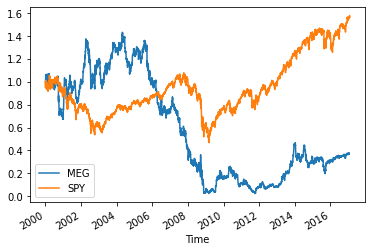

In [11]:
%%capture --no-display

path_load_rets = 'exhibits/meg-returns.xlsx'
tab_prices0 = pd.read_excel(path_load_rets,sheet_name='daily',index_col='Time')
tab_prices = tab_prices0.copy()
tab_prices[['MEG']] = tab_prices[['MEG']]/tab_prices.iloc[0,0]
tab_prices[['SPY']] = tab_prices[['SPY']]/tab_prices.iloc[0,1]
tab_prices.plot()
rets = (tab_prices.shift(0) / tab_prices.shift(1))-1

Roll_Max = tab_prices.rolling(252, min_periods=1).max()
Daily_Drawdown = tab_prices/Roll_Max - 1.0
mdd = Daily_Drawdown.min()

data = {'Mean':rets.mean()*252,
        'Mean Log':np.log(1+rets).mean()*252,
        'Vol':rets.std()*np.sqrt(252),
       'Max Drawdown':mdd}

retstats = pd.DataFrame(data)

retstats.style.format({
    'Mean': '{:.2%}'.format,
    'Mean Log': '{:.2%}'.format,
    'Vol': '{:.2%}'.format,
    'Max Drawdown': '{:.2%}'.format,
})


## Berkshire's Position in MEG

Exercised warrants very early, within months of deal, yet had 2020 expiration.
- Market took it as intention to sell.
- Why would this potentiallly impact MEG's price? Violation of Free-Portfolio Formation?
- Other explanation tying into why Buffett wanted a board seat of MEG?

Exercised at ~\$5 per share, but stock went > \$20 within months.
- But BH held most the shares.
- Cashed out in Nexstar acquisition at \$17/share, for ~\$60mm.

,Date
Buffett Aquisition,"May 17, 2012"
Buffett exercises warrants,Sep 2012
Buffetts stake reduced,2014
Nexstar agrees to acquire Media General,"Jan 27, 2016"
Nexstar closes on Media General,"Jan 17, 2017"


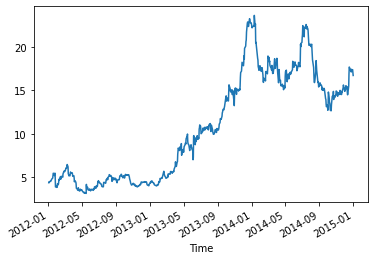

In [12]:
tab_prices0.loc['jan 01, 2012':'Dec 31, 2014','MEG'].plot()

data = {'Buffett Aquisition':['May 17, 2012'],
        'Buffett exercises warrants':['Sep 2012'],
        'Buffett''s stake reduced':['2014'],
        'Nexstar agrees to acquire Media General':['Jan 27, 2016'],
        'Nexstar closes on Media General':['Jan 17, 2017']}

events = pd.DataFrame(data).transpose()
events.columns = ['Date']
events


## Berkshire and Newspapers


- Buffett became more pessimistic by 2016.

- Berkshire sold their newspaper division in 2020 to Lee Enterprises (LEE) for \$140mm in cash. (Price includes more than just the newspapers from Media General.)

- Berkshire also provided LEE a loan of over \$500mm at over 9%!

*With few exceptions, when a managaer with a reputation for brilliance tackles a business with a reputation for poor economics, it is the reputation of the business that stays intact.*

- Warren Buffett, 1981

What do you think, did Buffett do well? Did MEG?

## References

[Acquisition of Newspapers](https://www.reuters.com/article/us-mediageneral/warren-buffett-to-buy-media-general-newspapers-idUSBRE84G0M920120517)

[Buffett's profit on the deal](https://www.thestreet.com/markets/mergers-and-acquisitions/warren-buffetts-warrants-shine-in-media-general-deal-12538603)

[Selling the newspapers](https://www.nytimes.com/2020/01/29/business/media/warren-buffett-newspapers.html)

[Making money off selling](https://www.ccn.com/simple-maneuver-will-help-warren-buffett-make-1-3-billion-in-dying-newspapers/)